In [1]:
from scipy.sparse import *
import numpy as np
import pickle
import random
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from scipy.sparse import csc_matrix as smatrix
import scipy
from operator import itemgetter
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
import pandas as pd
from copy import deepcopy

Using TensorFlow backend.


In [2]:
# load vocabulary
with open('vocab_full.pkl', 'rb') as f:
    vocab = pickle.load(f)
list(vocab.items())[:10]

[('psionics', 92309),
 ('gmail', 11781),
 ('izzit', 84272),
 ('99', 2904),
 ('samba', 23958),
 ('derwin', 77425),
 ('saquan', 91642),
 ('lima', 19064),
 ('ngerti', 41182),
 ('#usmc', 89671)]

In [3]:
# construct num -> word dict
reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))

In [4]:
# file -> [[word_number_1_1, ..., word_number_1_K1], ..., [word_number_L_1, ..., word_number_L_KL]]
def file_to_word2numbers(filename):
    data = open(filename, 'rb')
    word2numbers_all = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        word2numbers = []
        for word in line:
            if word in vocab: word2numbers.append(vocab[word])
        if word2numbers:
            word2numbers_all.append(word2numbers)
    return word2numbers_all

In [5]:
# loading data -> numbers of words
pos_numbers = file_to_word2numbers('../data/train_pos_full.txt')
neg_numbers = file_to_word2numbers('../data/train_neg_full.txt')

1250000it [00:10, 113858.79it/s]
1250000it [00:13, 93648.67it/s]


In [6]:
# number of word occurences as embeddings (basic embeddings)
def numbers_to_dataset(numbers):
    arr = {}
    for i, tweet in tqdm(enumerate(numbers)):
        for number in tweet:
            p = (i, number)
            if p in arr: arr[p] += 1
            else: arr[p] = 1
                    
    keys = list(arr.keys())
    values = [arr[k] for k in keys]
    return coo_matrix((values, ([x for x, y in keys], [y for x, y in keys])), shape=(len(numbers), len(vocab)))

In [7]:
# applying it to numbers
pos_data = numbers_to_dataset(pos_numbers)
neg_data = numbers_to_dataset(neg_numbers)

1249957it [00:12, 101538.38it/s]
1249964it [00:13, 90930.32it/s]


In [8]:
# constructing X, y pair
def two_datasets_to_one(pos_data, neg_data):
    assert pos_data.shape[1] == neg_data.shape[1]
    X = scipy.sparse.vstack((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    assert X.shape[1] == pos_data.shape[1]
    return X, y

In [9]:
# applying to datasets (pos & neg)
X, Y = two_datasets_to_one(pos_data, neg_data)

In [10]:
random_state = 42

In [39]:
# split to train/val
test_size_percent = 0.01
x, x_val, y, y_val = train_test_split(X, Y, test_size=test_size_percent, random_state=random_state)

In [22]:
input_dim = X.shape[1]
print(input_dim)

101299


In [ ]:
y = np.array(y).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
Y = np.array(Y).reshape(-1, 1)

In [31]:
X = X.tocsr()

In [14]:
def batch_generator(X, y, batch_size, number_of_batches):
    counter = 0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter = 0
def to_array_if_sparse(x):
    if type(x) is scipy.sparse.csr.csr_matrix:
        return x.toarray()
    return x
def predict(model, x, sz = 500):
    res = []
    N = x.shape[0]
    batches = N // sz
    if batches * sz < N:
        batches += 1
    for batch in tqdm(range(batches)):
        res += list(model.predict(to_array_if_sparse(x[batch * sz:(batch + 1) * sz,:])).flatten())
    return np.array(res).flatten()
def score(model, x, y):
    return np.mean((predict(model, x).flatten() > 0.5) == y.flatten())

In [23]:
def define_model(reg_l2, hidden_layers):
    model = Sequential()

    np.random.seed(random_state)

    kernel_regularizer = l2(reg_l2)

    # first hidden layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu', kernel_regularizer = kernel_regularizer))

    # hidden layers
    for neurons_n in hidden_layers[1:]:
        model.add(Dense(neurons_n, activation='relu', kernel_regularizer=kernel_regularizer))

    #output layer
    model.add(Dense(1, activation='sigmoid', kernel_regularizer = kernel_regularizer))

    # showing accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [24]:
def get_model_history(reg_l2, hidden_layers = (100, 10), nb_epoch = 30, return_model = False):
    
    model = define_model(reg_l2, hidden_layers)
    
    # setting parameters
    batch_size = 1000
    nb_batches = x.shape[0] / batch_size
    generator = batch_generator(x, y, batch_size, nb_batches)

    # training model
    history = model.fit_generator(generator = generator, epochs = nb_epoch, 
                        steps_per_epoch = nb_batches, validation_data=(x_val.toarray(), y_val))
    
    res = deepcopy(history.history)
    
    if not return_model:
        del model
        return res
    else:
        return model, res

In [25]:
regularizers = np.logspace(-7, 0, num = 5)

# high overfit
#hidden_layers = (100, 10)

# high bias (0.82 max val acc)
#hidden_layers = (10, 5)

# still 0.83 MAX -> switching to FULL dataset
hidden_layers = (50, 10, 5)

nb_epoch = 3

In [34]:
results = []
for i, value in enumerate(regularizers):
    print("Running with %s %d/%d" % (str(value), i, len(regularizers)))
    history = get_model_history(value, nb_epoch = nb_epoch, hidden_layers = hidden_layers)
    results.append(history)

Running with 1e-07 0/5
Epoch 1/3
2475/2474 [==============================] - 2111s 853ms/step - loss: 0.3427 - acc: 0.8454 - val_loss: 0.3166 - val_acc: 0.8578
Epoch 2/3
2475/2474 [==============================] - 2102s 849ms/step - loss: 0.2912 - acc: 0.8711 - val_loss: 0.3142 - val_acc: 0.8612
Epoch 3/3
2475/2474 [==============================] - 2110s 853ms/step - loss: 0.2627 - acc: 0.8857 - val_loss: 0.3216 - val_acc: 0.8601
Running with 5.6234132519e-06 1/5
Epoch 1/3
2475/2474 [==============================] - 2102s 849ms/step - loss: 0.3510 - acc: 0.8448 - val_loss: 0.3297 - val_acc: 0.8571
Epoch 2/3
2475/2474 [==============================] - 2126s 859ms/step - loss: 0.3158 - acc: 0.8655 - val_loss: 0.3285 - val_acc: 0.8594
Epoch 3/3
2475/2474 [==============================] - 2082s 841ms/step - loss: 0.3019 - acc: 0.8747 - val_loss: 0.3316 - val_acc: 0.8611
Running with 0.000316227766017 2/5
Epoch 1/3
2475/2474 [==============================] - 2083s 842ms/step - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#resultss_ep1 = deepcopy(results)
#pickle.dump(results_ep1, open('results_ep1.txt', 'wb'))

In [ ]:
for i in range(len(regularizers)):
    results[i]['l2'] = regularizers[i]

In [35]:
#results_ep30 = deepcopy(results)
#pickle.dump(results, open('results_full_2.txt', 'wb'))

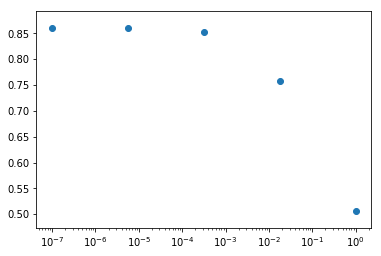

In [38]:
ax = plt.gca()
ax.set_xscale('log')
ax.scatter(regularizers, [max(result['val_acc']) for result in results])
#ax.scatter(regularizers[:-1], [max(result['val_acc']) for result in results][:-1])
#ax.scatter(regularizers[:-1], [result['val_acc'][-1] for result in results][:-1])

In [41]:
list(zip([(i, max(x['val_acc']), np.argmax(x['val_acc'])) for i, x in enumerate(results)], regularizers))

[((0, 0.86120000311613087, 1), 9.9999999999999995e-08),
 ((1, 0.86112000039339065, 2), 5.6234132519034912e-06),
 ((2, 0.85276000379085537, 2), 0.00031622776601683794),
 ((3, 0.75807999483346944, 0), 0.017782794100389229),
 ((4, 0.50627999366164211, 1), 1.0)]

In [63]:
model = define_model(regularizers[0], hidden_layers)
    
# setting parameters
batch_size = 1000
nb_batches = X.shape[0] / batch_size
generator = batch_generator(X, Y, batch_size, nb_batches)

# training model
history = model.fit_generator(generator = generator, epochs = 2, steps_per_epoch = nb_batches)

Epoch 1/2
2500/2499 [==============================] - 2066s 827ms/step - loss: 0.3424 - acc: 0.8455
Epoch 2/2
2500/2499 [==============================] - 2068s 827ms/step - loss: 0.2910 - acc: 0.8710


In [64]:
def plot_history(history):
    #print(history.keys())
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

KeyError: 'val_acc'

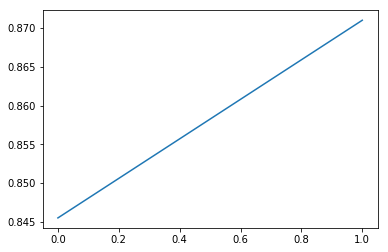

In [66]:
plot_history(history.history)

In [41]:
# print resulting train/val losses
print('Accuracy on train: %.3f, on validation: %.3f' % (score(model, x, y), score(model, x_val, y_val)))

  0%|          | 8/4950 [00:04<50:16,  1.64it/s]


KeyboardInterrupt: 

In [67]:
# plot ROC curve
def plot_ROC(x, y, model):
    fpr, tpr, _ = roc_curve(y, predict(model, x))
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


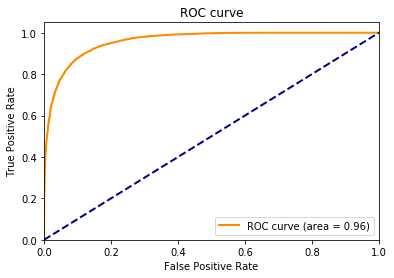

In [68]:
plot_ROC(x_val, y_val, model)

In [ ]:
plot_ROC(x, y, model)

In [69]:
# open train and predict
def test_to_dataset(filename):
    data = open(filename, 'rb')
    idxes = []
    tweets_embeddings = []
    
    for line in tqdm(data):
        idx, line = line.strip().decode("utf-8").split(',', 1)
        idxes.append(idx)
        line = line.split(' ')
        tweet = []
        
        tweet_embeddings = np.zeros((len(vocab), ), dtype=np.float32)
        
        for word in line:
            if word in vocab:
                tweet_embeddings[vocab[word]] += 1
                
        tweets_embeddings.append(tweet_embeddings)
        
    #return tweets_embeddings
    tweets_embeddings = np.array(tweets_embeddings)
    assert len(idxes) == tweets_embeddings.shape[0]
    assert tweets_embeddings.shape[1] == len(vocab)
    return idxes, tweets_embeddings

In [70]:
idx_test, X_test = test_to_dataset('../data/test_data.txt')

10000it [00:01, 7865.13it/s]


In [71]:
pred = predict(model, X_test)

100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


In [72]:
y_predicted = [1 if x > 0.5 else -1 for x in pred]

In [73]:
answers = sorted(zip(idx_test, y_predicted), key = lambda x: int(x[0]))
f = open('submission_wc_full_cv_3.txt', 'w')
f.write("Id,Prediction\n")
for idx, ans in answers:
    f.write("%s,%s\n" % (idx, ans))
f.close()